In [267]:
import numpy as np
import emcee
import pandas as pd
import corner
from scipy.optimize import minimize

import time
from multiprocessing import Pool

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [Zheng & Filippenko (2016)](https://arxiv.org/pdf/1612.02097.pdf), a broken power-law parameterization of SN Ia light curves is introduced. This parameterization is somewhat physically motivated, however, there are some assumptions that break down for some SNe Ia. A major advantage of this method, however, is that it covers the peak and turn-over of SN light curves, so there is no need to artificially truncate the data (to ~5 d after explosion for example) in order to only fit the early rise. 

The formulation is: 

$$L = A' \left(\frac{t - t_0}{t_b}\right)^{\alpha_\mathrm{r}} \left[1 + \left(\frac{t - t_0}{t_b}\right)^{s\alpha_\mathrm{d}}\right]^{-2/s}$$

which has a peak value when:

$$ t_p = t_b \times \left(-\frac{\alpha_1 + 1}{\alpha_2 + 1}\right)^{1/[s(\alpha_1 + \alpha_2)]} $$

and:

$$ \begin{align} \alpha_\mathrm{r} & = & 2(\alpha_1 + 1) \\ \alpha_\mathrm{d} & = & \alpha_1 - \alpha_2 \end{align}. $$

This parameterization has some additional constraints on the parameters, in particular, for $t \gg t_b$ if $\alpha_\mathrm{d} < \alpha_\mathrm{r}/2$ then the SN will not actually decline. $t_b$ is the break in the light curve, and is close to the rise time of the SN, assuming small $\alpha_1$ and $\alpha_2 \approx -2$.

In [145]:
def f_t(times, amplitude=25, t_b=20, t_0=0, alpha_r=2, alpha_d=2, s=2):
    time_term = (times - t_0)/t_b
    
    return amplitude * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)

In [268]:
def lnlikelihood(theta, f, t, f_err):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s, sig_0 = theta

    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)/t_b
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)
    
    ln_l = np.sum(np.log(1. / np.sqrt(2*np.pi * (sig_0**2 + f_err**2))) - ((f - model)**2 / (2 * (sig_0**2 + f_err**2))))
    return ln_l

def lnlikelihood_no_sig0(theta, f, t, f_err):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s = theta

    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)/t_b
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)
    
#     ln_l = np.sum(np.log(1. / np.sqrt(2*np.pi * (f_err**2))) - ((f - model)**2 / (2 * (f_err**2))))
    ln_l = -1/2*np.sum(((f - model)/f_err)**2) + np.sum(np.log(1/np.sqrt(2*np.pi*f_err**2)))
    
#     print(-1/2*np.sum(((f_data - model)/f_unc_data)**2) + np.sum(np.log(1/np.sqrt(2*np.pi*f_unc_data**2))))
    
    return ln_l

def nll(theta, f, t, f_err):
    return -1*lnlikelihood_no_sig0(theta, f, t, f_err)

#Define priors on parameters  
def lnprior(theta):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s, sig_0 = theta
    if (-100 < t_0 < 100 and 0 < alpha_r < 100 and 
        0 < alpha_d < 100 and 0 < sig_0 < 10000 and 
        -1000 < a < 1000 and  0 < t_b < 1000 and 
        0 < s < 1000 and 0 < a_prime < 1e6):
        return 0.0
    return -np.inf

def lnprior_no_sig0(theta):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s = theta
    if (-100 < t_0 < 100 and 0 < alpha_r < 100 and 
        0 < alpha_d < 100 and
        -1000 < a < 1000 and  0 < t_b < 1000 and 
        0 < s < 1000 and 0 < a_prime < 1e6):
        return 0.0
    return -np.inf

def lnposterior(theta, f, t, f_err):
    lnp = lnprior_no_sig0(theta)
    lnl = lnlikelihood_no_sig0(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp 

In [192]:
def gen_zheng_lc(times, baseline=0, t_exp=0, alpha_r=2, 
                 alpha_d=2, s=2, t_b=18,
                 amplitude=2e4, sigma_sys=5):
    '''
    Generate a simple SN Ia-like light curve
    
    Parameters
    ----------
    
    times : array-like
        The times at which the simulated data should be generated.
        Times are in units of days.
    
    baseline : float, optional (default=0)
        The baseline value for the flux of the transient in the 
        telescope system.
    
    t_exp : float, optional (default=0)
        The time of explosion for the SN.
    
    alpha_r : float, optional (default=2)
        Power-law index for the initial rise of the SN.

    alpha_d : float, optional (default=2)
        Power-law index for the late time decay of the SN.
    
    s : float, optional (default=2)
        Smoothing parameter for the broken power-law model.

    amplitude : float, optional (default=2e4)
        Normalizing amplitude for the SN, the default value
        is determined by assuming all default parameters, 
        and a telescope system with 25 mag zeropoint.
    
    sigma_sys : float, optional (default=5)
        The systematic noise present in the light curves due to 
        the telescope system. The default value is determined from 
        assuming a telescope limiting magnitude of 21.5.
    
    Returns
    -------
    cnts : array-like, shape=shape(times)
        The counts corresponding to the SN flux, after taking into 
        account the noise associated with the detector
    
    cnts_unc : array-like, shape=shape(times)
        Uncertainty in the number of counts from the SN
    '''
    
    cnts = np.zeros_like(times)
    cnts_unc = np.zeros_like(times)

    pre_explosion = np.logical_not(times > t_exp)
    cnts[pre_explosion] = np.random.normal(baseline, sigma_sys, size=sum(pre_explosion))
    cnts_unc[pre_explosion] = np.ones_like(times)[pre_explosion]*sigma_sys

    time_term = (times[~pre_explosion] - t_exp)/t_b
    sn_flux = amplitude * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)
    sn_with_random_noise = sn_flux + np.random.normal(np.zeros_like(sn_flux), np.sqrt(sn_flux))
    sn_with_random_plus_sys = sn_with_random_noise + np.random.normal(baseline, sigma_sys, size=len(sn_flux))

    # total uncertainty = systematic + Poisson
    sn_uncertainties = np.hypot(np.sqrt(np.maximum(sn_with_random_noise, np.zeros_like(sn_with_random_noise))), 
                                sigma_sys)

    cnts[~pre_explosion] = sn_with_random_plus_sys
    cnts_unc[~pre_explosion] = sn_uncertainties

    return cnts, cnts_unc

In [375]:
t_obs=np.arange(-30,30)
cnts, cnts_unc = gen_zheng_lc(t_obs, amplitude=3e4, sigma_sys=3)

<IPython.core.display.Javascript object>


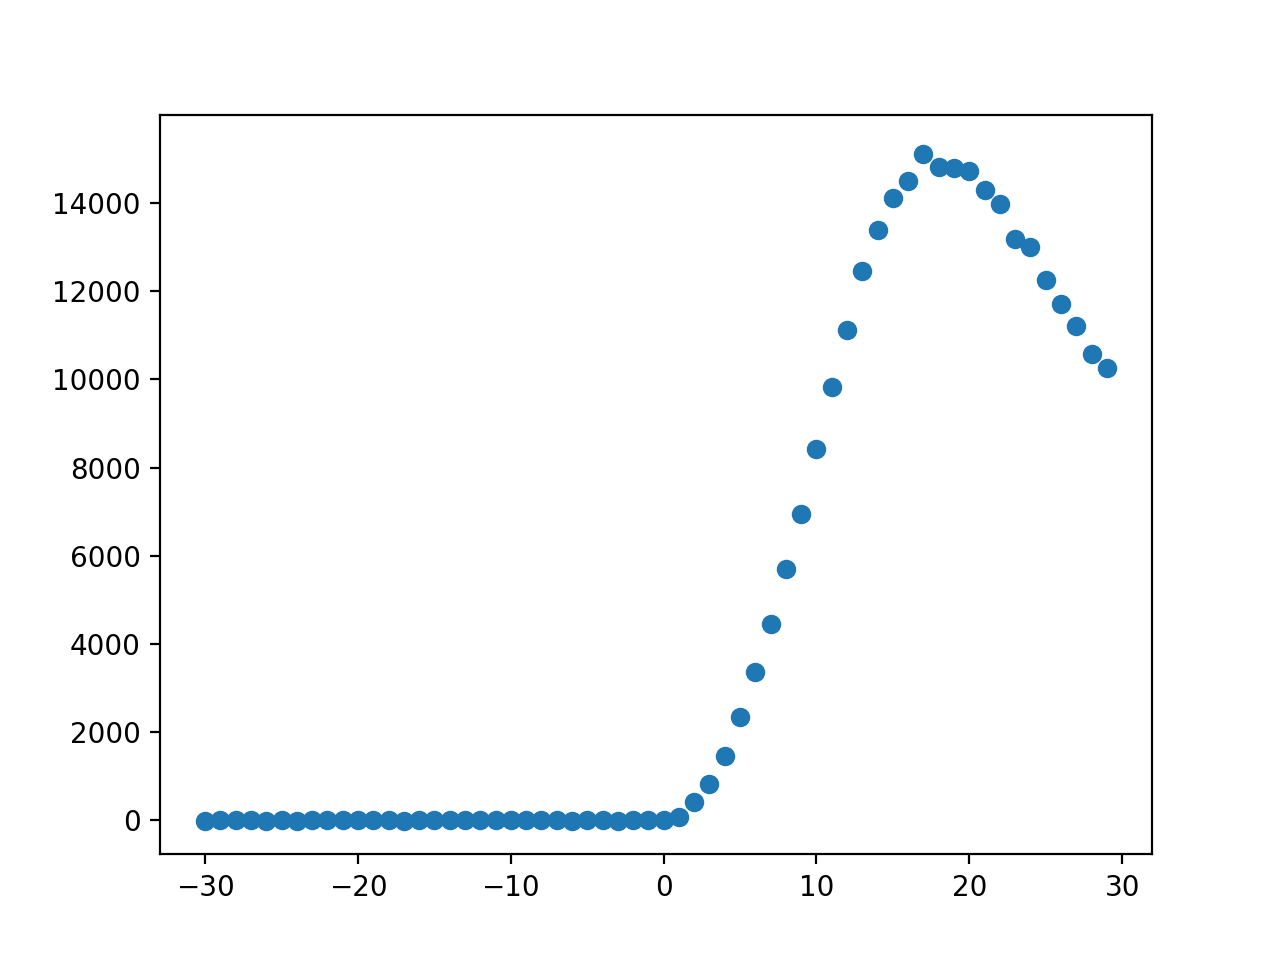

0.060327503608756106


In [377]:
plt.figure()
plt.errorbar(t_obs, cnts, cnts_unc, fmt='o')
print(10**(37/5+1)*72/1e6/2.9979e5)

In [360]:

guess_0 = [0, 1e4, 0, 20, 1.5, 1.5, 1]
ml_res = minimize(nll, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(f_data, t_data, f_unc_data))
ml_guess = ml_res.x
ml_guess

array([1.50873108e-01, 1.86957550e+03, 1.17624475e+00, 2.42026274e+01,
       1.69262420e+00, 2.79855792e+00, 8.99808406e-01])

In [361]:
# setup various emcee parameters

#initial guess on parameters
guess_0 = [0, 1e4, 0, 20, 1.5, 1.5, 1]

# initialize near maximum-likelihood result
ml_res = minimize(nll, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(f_data, t_data, f_unc_data))
ml_guess = ml_res.x

#number of walkers
nwalkers = 500
nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
ndim = len(ml_guess)

#initial position of walkers
pos = [ml_guess + nfac * np.random.randn(ndim) for i in range(nwalkers)]

# light curve to fit
det = np.where(cnts/cnts_unc >= 4)
t_data = t_obs
f_data = cnts
f_unc_data = cnts_unc

#run initial burn-in
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
nsamples = 5000
foo = sampler.run_mcmc(pos, nsamples)



/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


<IPython.core.display.Javascript object>


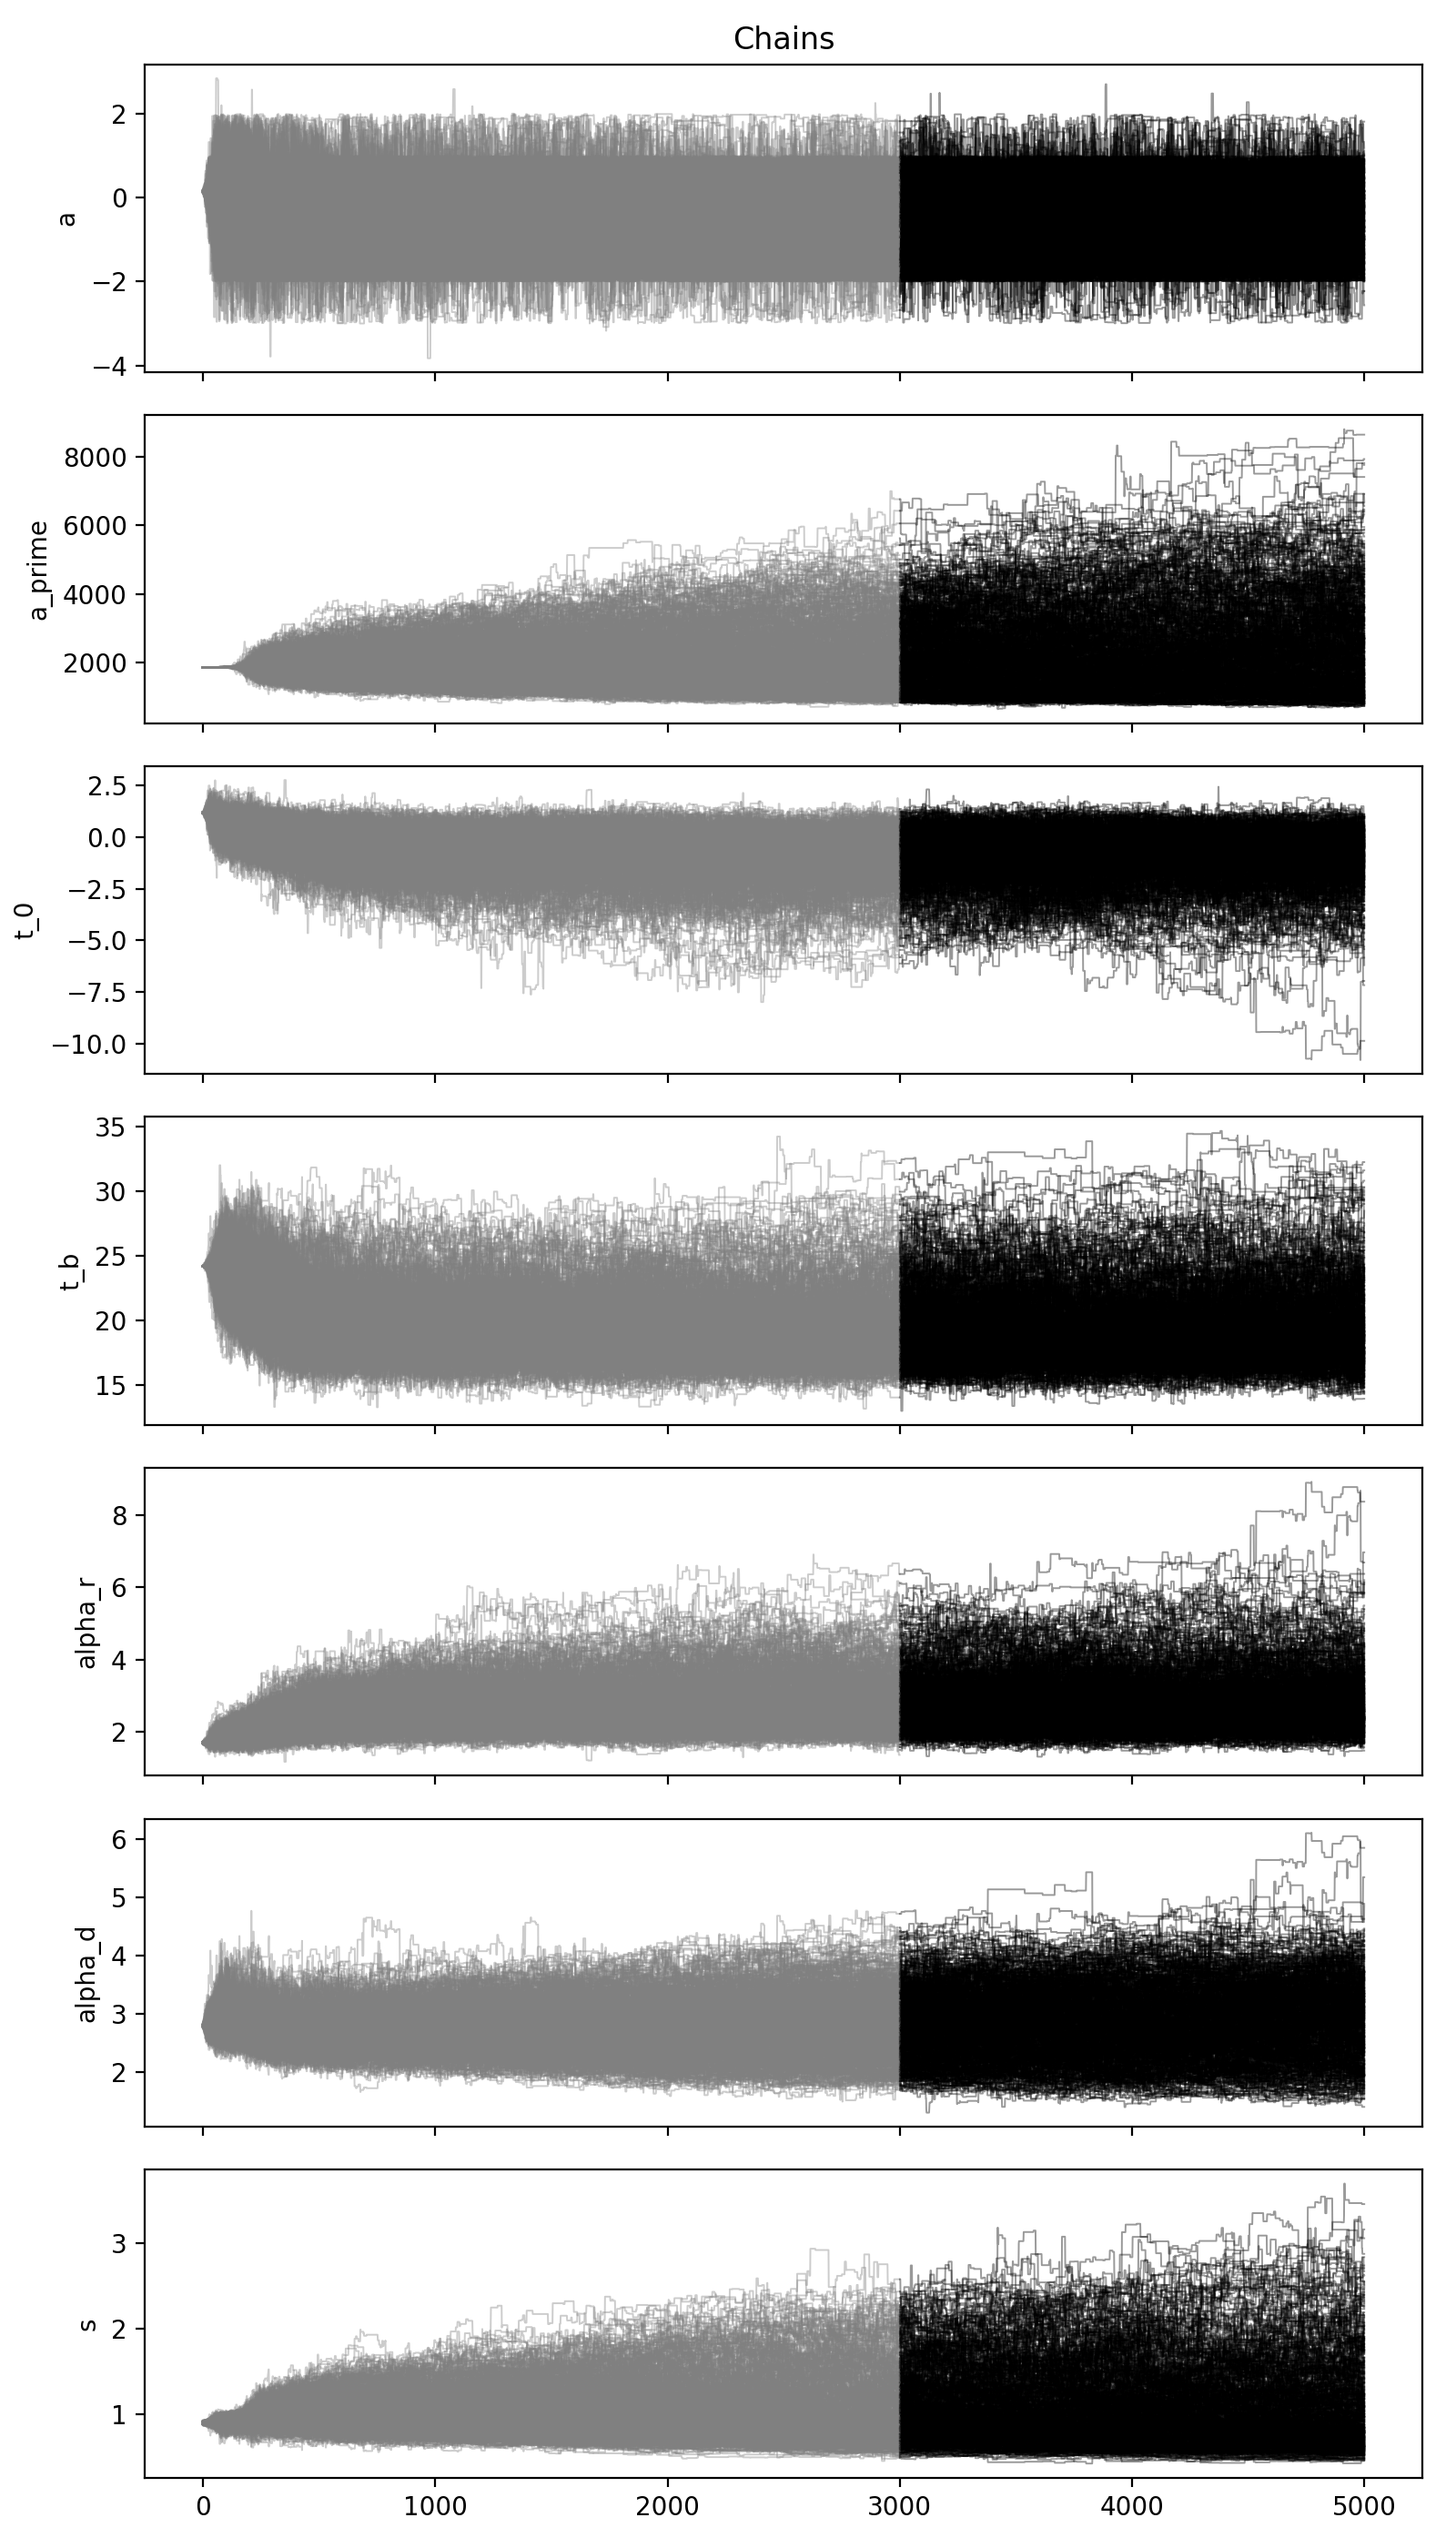

In [362]:
ax = plotChains(sampler, nburn, paramsNames)
plt.show()
plt.tight_layout()

<IPython.core.display.Javascript object>


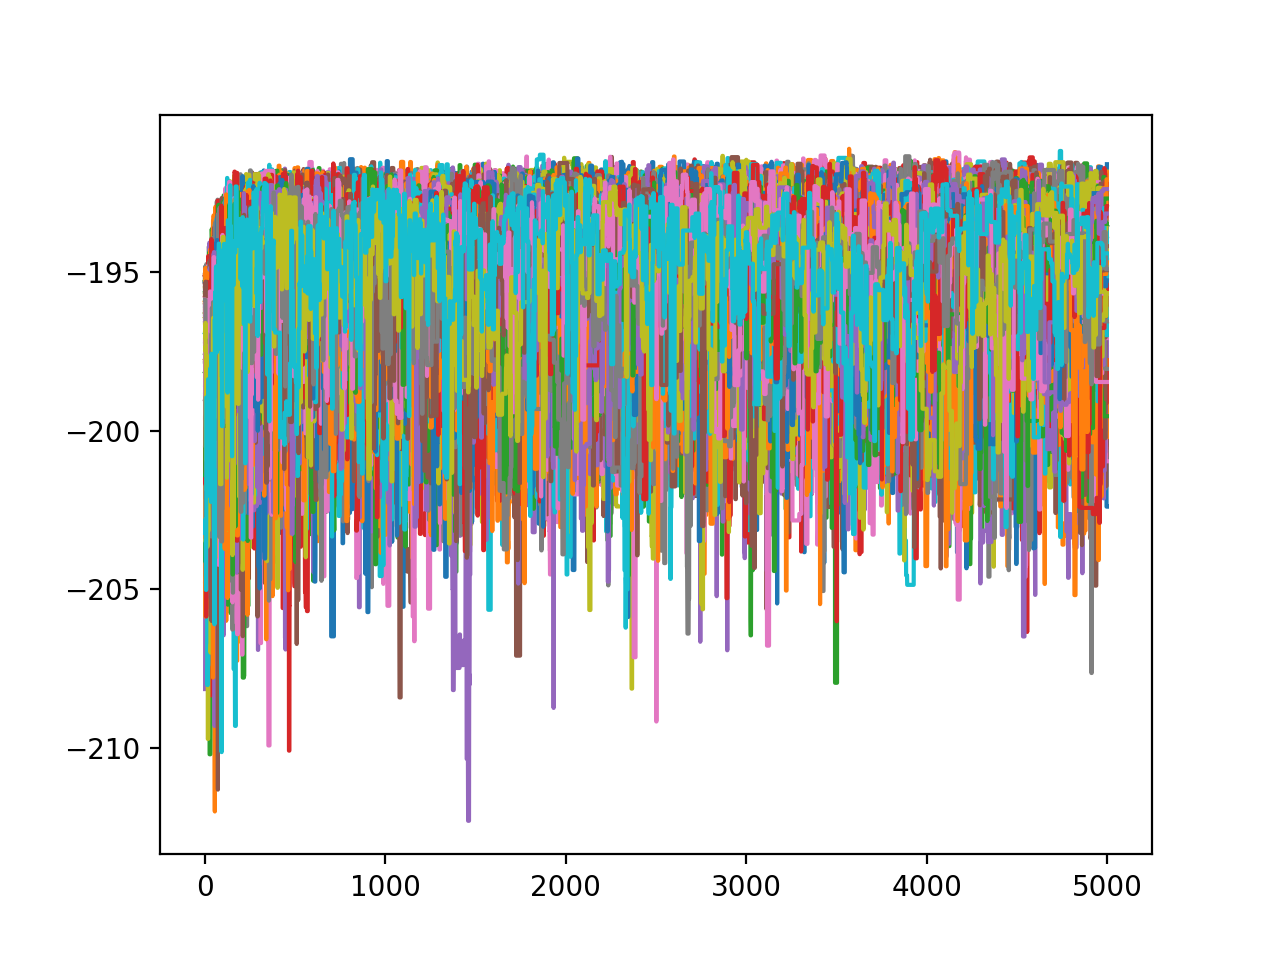

In [363]:
plt.figure()
for i in range(nwalkers):
    plt.plot(sampler.lnprobability[:,i])

In [364]:
burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
burn_max_post

array([-1.68773553e+00,  9.95016179e+02, -4.58795455e-02,  1.74835170e+01,
        2.02954578e+00,  1.94522191e+00,  1.90697741e+00])

In [365]:
sampler.lnprobability[-1,:]

array([-192.29522166, -194.27988051, -195.51649495, -193.78193911,
       -193.94865398, -194.3426735 , -193.50950804, -193.67832305,
       -195.07685018, -196.53533549, -202.39262606, -194.47333482,
       -195.08002568, -193.15929214, -194.72891738, -192.78294005,
       -193.93940518, -197.48501694, -193.30685426, -193.24580717,
       -194.31352446, -193.52976959, -193.46143866, -192.64806964,
       -193.45087045, -193.74526304, -193.41730629, -196.3885126 ,
       -193.87519617, -192.35606325, -194.55197332, -199.25291768,
       -192.10058031, -200.53200035, -193.13075899, -193.98426478,
       -194.62002103, -192.94203125, -192.3550664 , -195.49612364,
       -200.08854289, -193.08128978, -196.06202895, -197.20337019,
       -193.89804662, -197.12209906, -194.43862483, -195.45106872,
       -199.36595515, -192.72645571, -193.35854018, -192.03361347,
       -194.58874782, -193.88996633, -195.25560198, -195.04604327,
       -200.74835997, -194.75612571, -193.19237779, -193.13015

In [366]:
lnposterior(burn_max_post, f_data, t_data, f_unc_data)

-191.5889259688203

In [368]:
# run second burn in
burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), threads = ncores)
nsamples = 15000
foo = sampler.run_mcmc(pos, nsamples)
 

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


In [369]:
# set a "burn-in" limit
burnin = 3000

samples = sampler.get_chain(discard=burnin, flat=True)

a_mc, a_prime_mc, t_0_mc, t_b_mc, alpha_r_mc, alpha_d_mc, s_mc = map(lambda v: (v[0], v[1], v[2], v[3], v[4]), 
                                                                     zip(*np.percentile(samples, [2.5, 16, 50, 84, 97.5], axis=0)))


In [370]:
print("emcee results with 68% credible regions\n \
      t_0 = {:.4f} -{:.4f} +{:.4f}\n \
      t_b = {:.4f} -{:.4f} +{:.4f}\n \
      alpha_r = {:.4f} -{:.4f} +{:.4f}\n \
      alpha_d = {:.4f} -{:.4f} +{:.4f}\n \
      a = {:.4f} -{:.4f} +{:.4f}\n \
      a_prime = {:.4f} -{:.4f} +{:.4f}\n \
      s = {:.4f} -{:.4f} +{:.4f}\n" # \
#       sig_0 = {:.4f} -{:.4f} +{:.4f}\n" \
      .format(t_0_mc[2], t_0_mc[2] - t_0_mc[1], t_0_mc[3] - t_0_mc[2], 
              t_b_mc[2], t_b_mc[2] - t_b_mc[1], t_b_mc[3] - t_b_mc[2],
              alpha_r_mc[2], alpha_r_mc[2] - alpha_r_mc[1], alpha_r_mc[3] - alpha_r_mc[2], 
              alpha_d_mc[2], alpha_d_mc[2] - alpha_d_mc[1], alpha_d_mc[3] - alpha_d_mc[2], 
              a_mc[2], a_mc[2] - a_mc[1], a_mc[3] - a_mc[2],
              a_prime_mc[2], a_prime_mc[2] - a_prime_mc[1], a_prime_mc[3] - a_prime_mc[2],
              s_mc[2], s_mc[2] - s_mc[1], s_mc[3] - s_mc[2]))#,
#               sig_0_mc[2], sig_0_mc[2] - sig_0_mc[1], sig_0_mc[3] - sig_0_mc[2]))

emcee results with 68% credible regions
       t_0 = -0.2398 -1.4086 +0.8594
       t_b = 17.3794 -1.8621 +2.9457
       alpha_r = 2.2639 -0.4863 +0.8899
       alpha_d = 2.2638 -0.7353 +0.8895
       a = -0.4523 -1.0143 +0.9512
       a_prime = 1234.1185 -510.7091 +1297.0987
       s = 1.4347 -0.6261 +1.8751



<IPython.core.display.Javascript object>


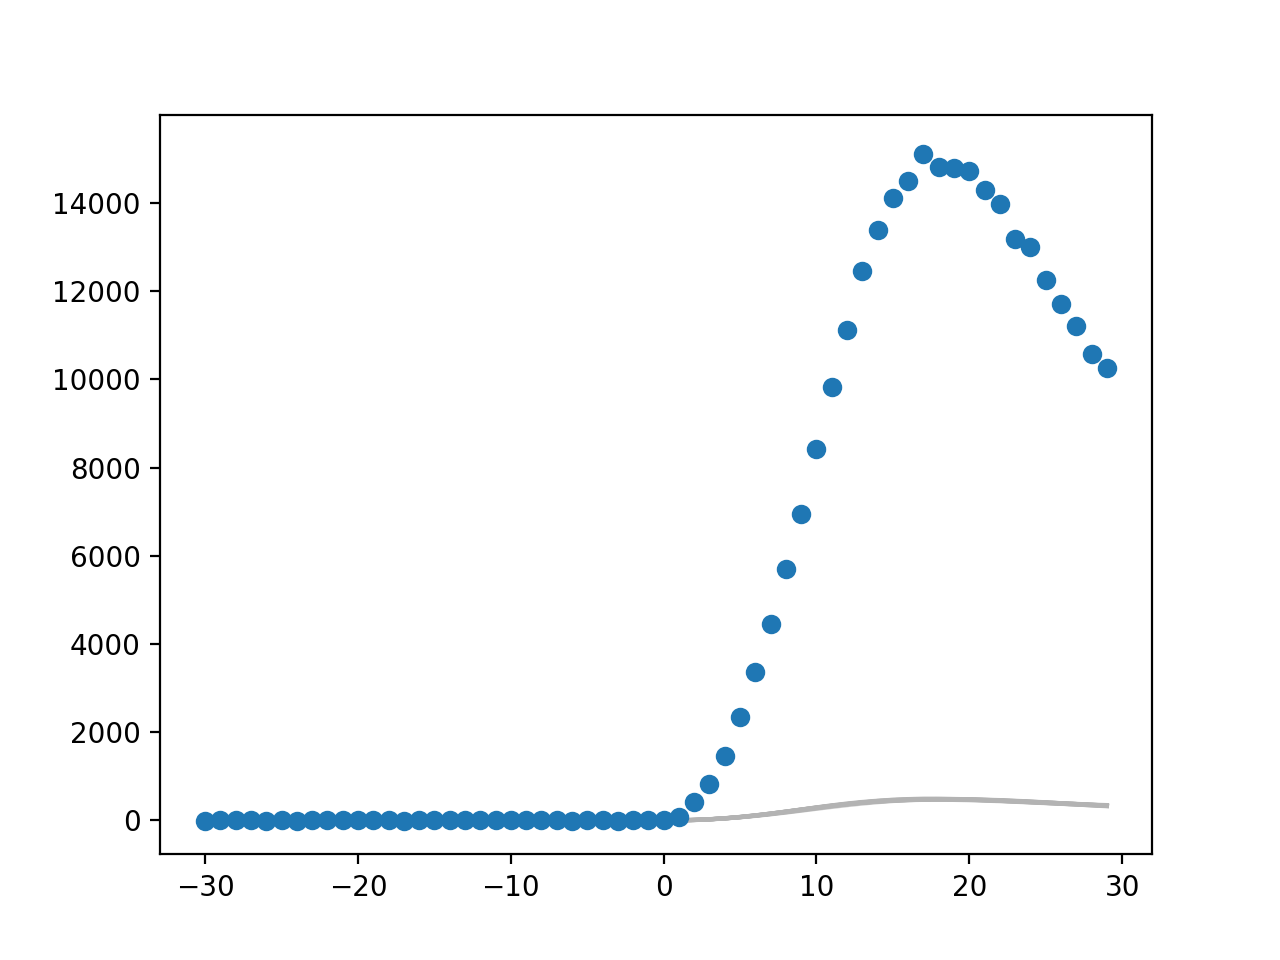

290
[-1.29467679e+00  3.50443586e+03 -7.33779980e+00  1.85761980e+01
  7.51702842e+00  5.22197211e+00  6.04204909e-01]
245
[-1.21047640e+00  2.73046589e+03 -3.62194455e-01  1.97031919e+01
  2.63683662e+00  2.84022951e+00  7.87144180e-01]
61
[ 7.40402592e-01  4.03417229e+03 -4.05625311e-01  2.49172160e+01
  2.49876732e+00  3.62126328e+00  6.05139381e-01]
377
[ 7.42993338e-01  2.80454257e+03 -4.78652603e-01  2.13157888e+01
  2.57025878e+00  3.01277565e+00  7.71765270e-01]
116
[-8.63355262e-02  3.37442533e+03  8.80717796e-02  2.20670264e+01
  2.46624018e+00  3.11097043e+00  6.90074348e-01]
468
[-1.13485202e+00  3.41971525e+03 -1.27390527e+00  2.54845974e+01
  2.69970770e+00  3.78397184e+00  6.66039516e-01]
340
[  0.73962111 665.1685974    0.84606232  15.41330279   1.66626995
   1.37881693   4.45421608]
98
[-3.92363715e-01  1.67976252e+03 -4.29329306e-01  1.80513451e+01
  2.51698044e+00  2.50948053e+00  1.10943999e+00]
499
[-1.17737875e+00  8.16014334e+02 -2.40103655e-03  1.62142313e+01
  

In [379]:
plt.figure()
plt.errorbar(t_obs, cnts, cnts_unc, fmt='o')
burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
max_post_model = burn_max_post[0] + f_t(t_obs[t_obs > 0], amplitude=burn_max_post[1], 
                                        t_0=burn_max_post[2], t_b=burn_max_post[3], 
                                        alpha_r=burn_max_post[4], alpha_d=burn_max_post[5], 
                                        s=burn_max_post[6])
plt.plot(t_obs[t_obs > 0], max_post_model, "0.7", alpha=0.7)

for samp_num in np.random.randint(0, len(sampler.chain[:,-1,:]), size=10):
    print(samp_num)
    sample = sampler.chain[:,-1,:][samp_num]
    print(sample)
    flux_fit = f_t(t_obs[t_obs > 0], amplitude=sample[1], t_0=sample[2], t_b=sample[3], 
                        alpha_r=sample[4], alpha_d=sample[5], s=sample[6])
    plt.plot(t_obs[t_obs > 0], flux_fit, "0.7", alpha=0.7)

# plt.ylim(0,4e4)

In [372]:
max_post_model

array([  1.58856574,  11.0955996 ,  26.9460451 ,  49.10770965,
        77.37813707, 111.31380898, 150.15703674, 192.7850408 ,
       237.70654257, 283.12659158, 327.0858558 , 367.65779931,
       403.16430968, 432.35899022, 454.53500155, 469.53843021,
       477.6970395 , 479.69496139, 476.4299221 , 468.88289959,
       458.01738372, 444.71311399, 429.73080693, 413.70047523,
       397.1253481 , 380.39461404, 363.80003405, 347.5532208 ,
       331.80175664])

<IPython.core.display.Javascript object>


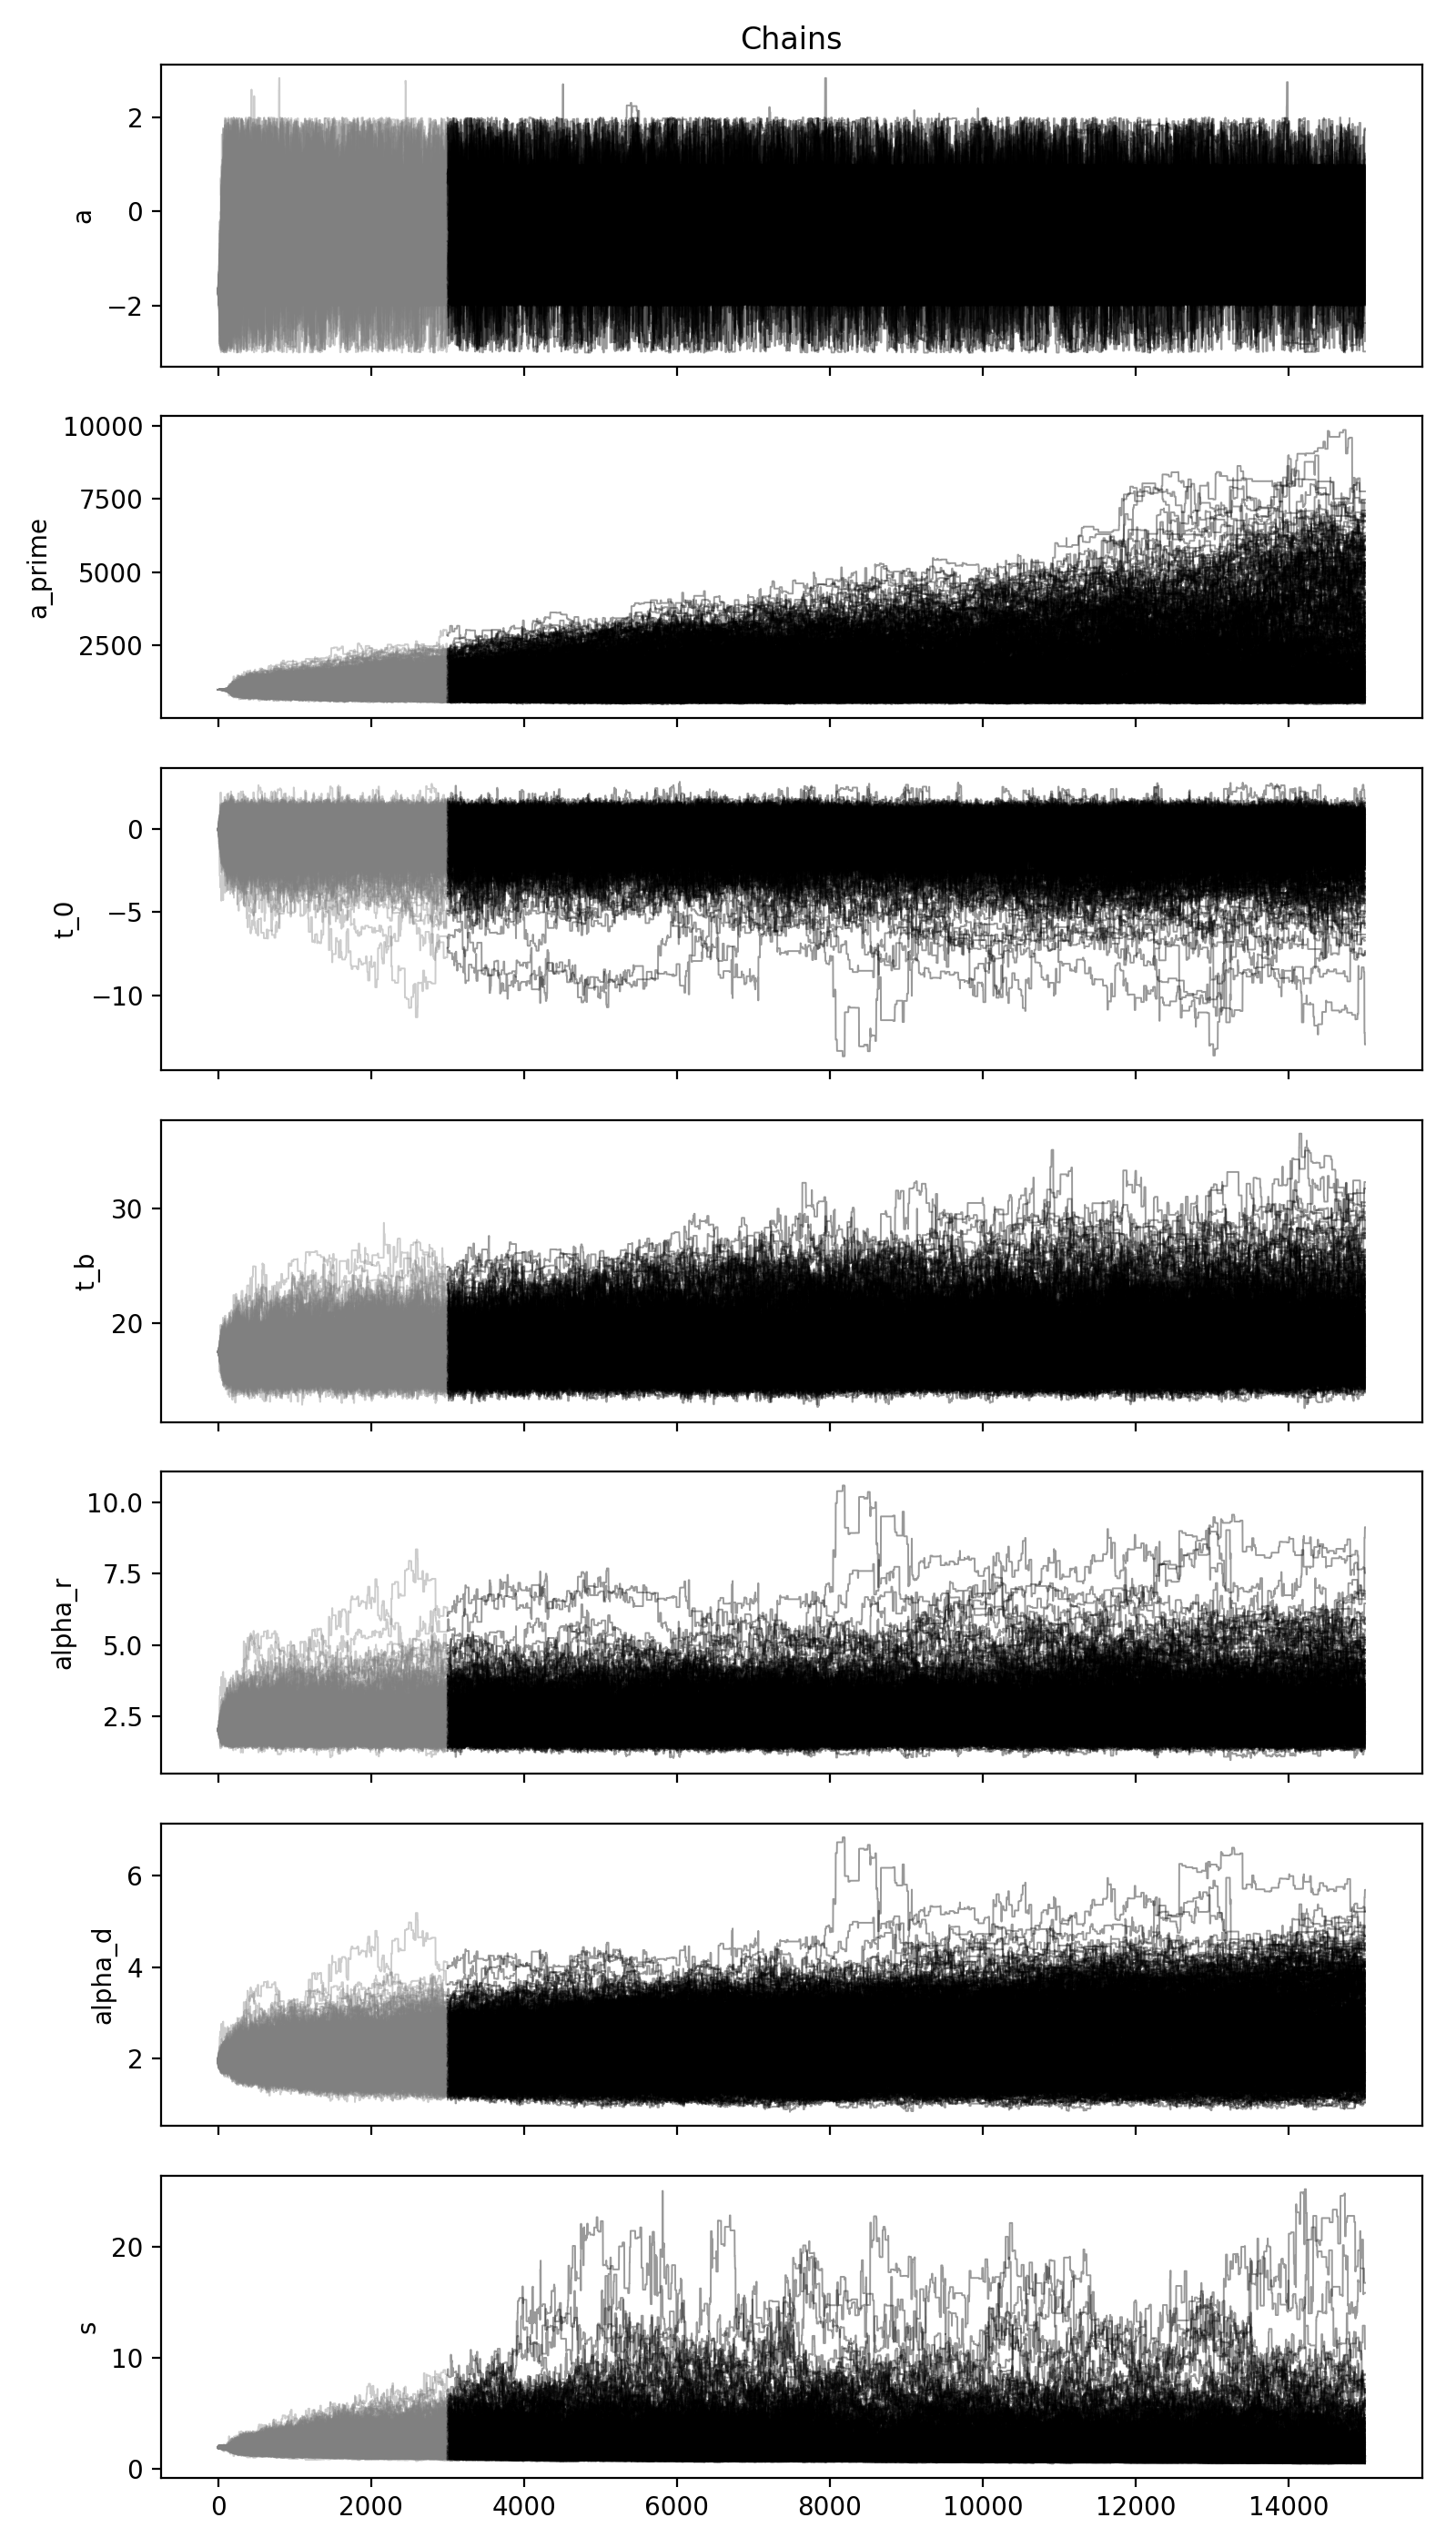

In [373]:
ax = plotChains(sampler, burnin, paramsNames)
plt.show()
plt.tight_layout()

<IPython.core.display.Javascript object>


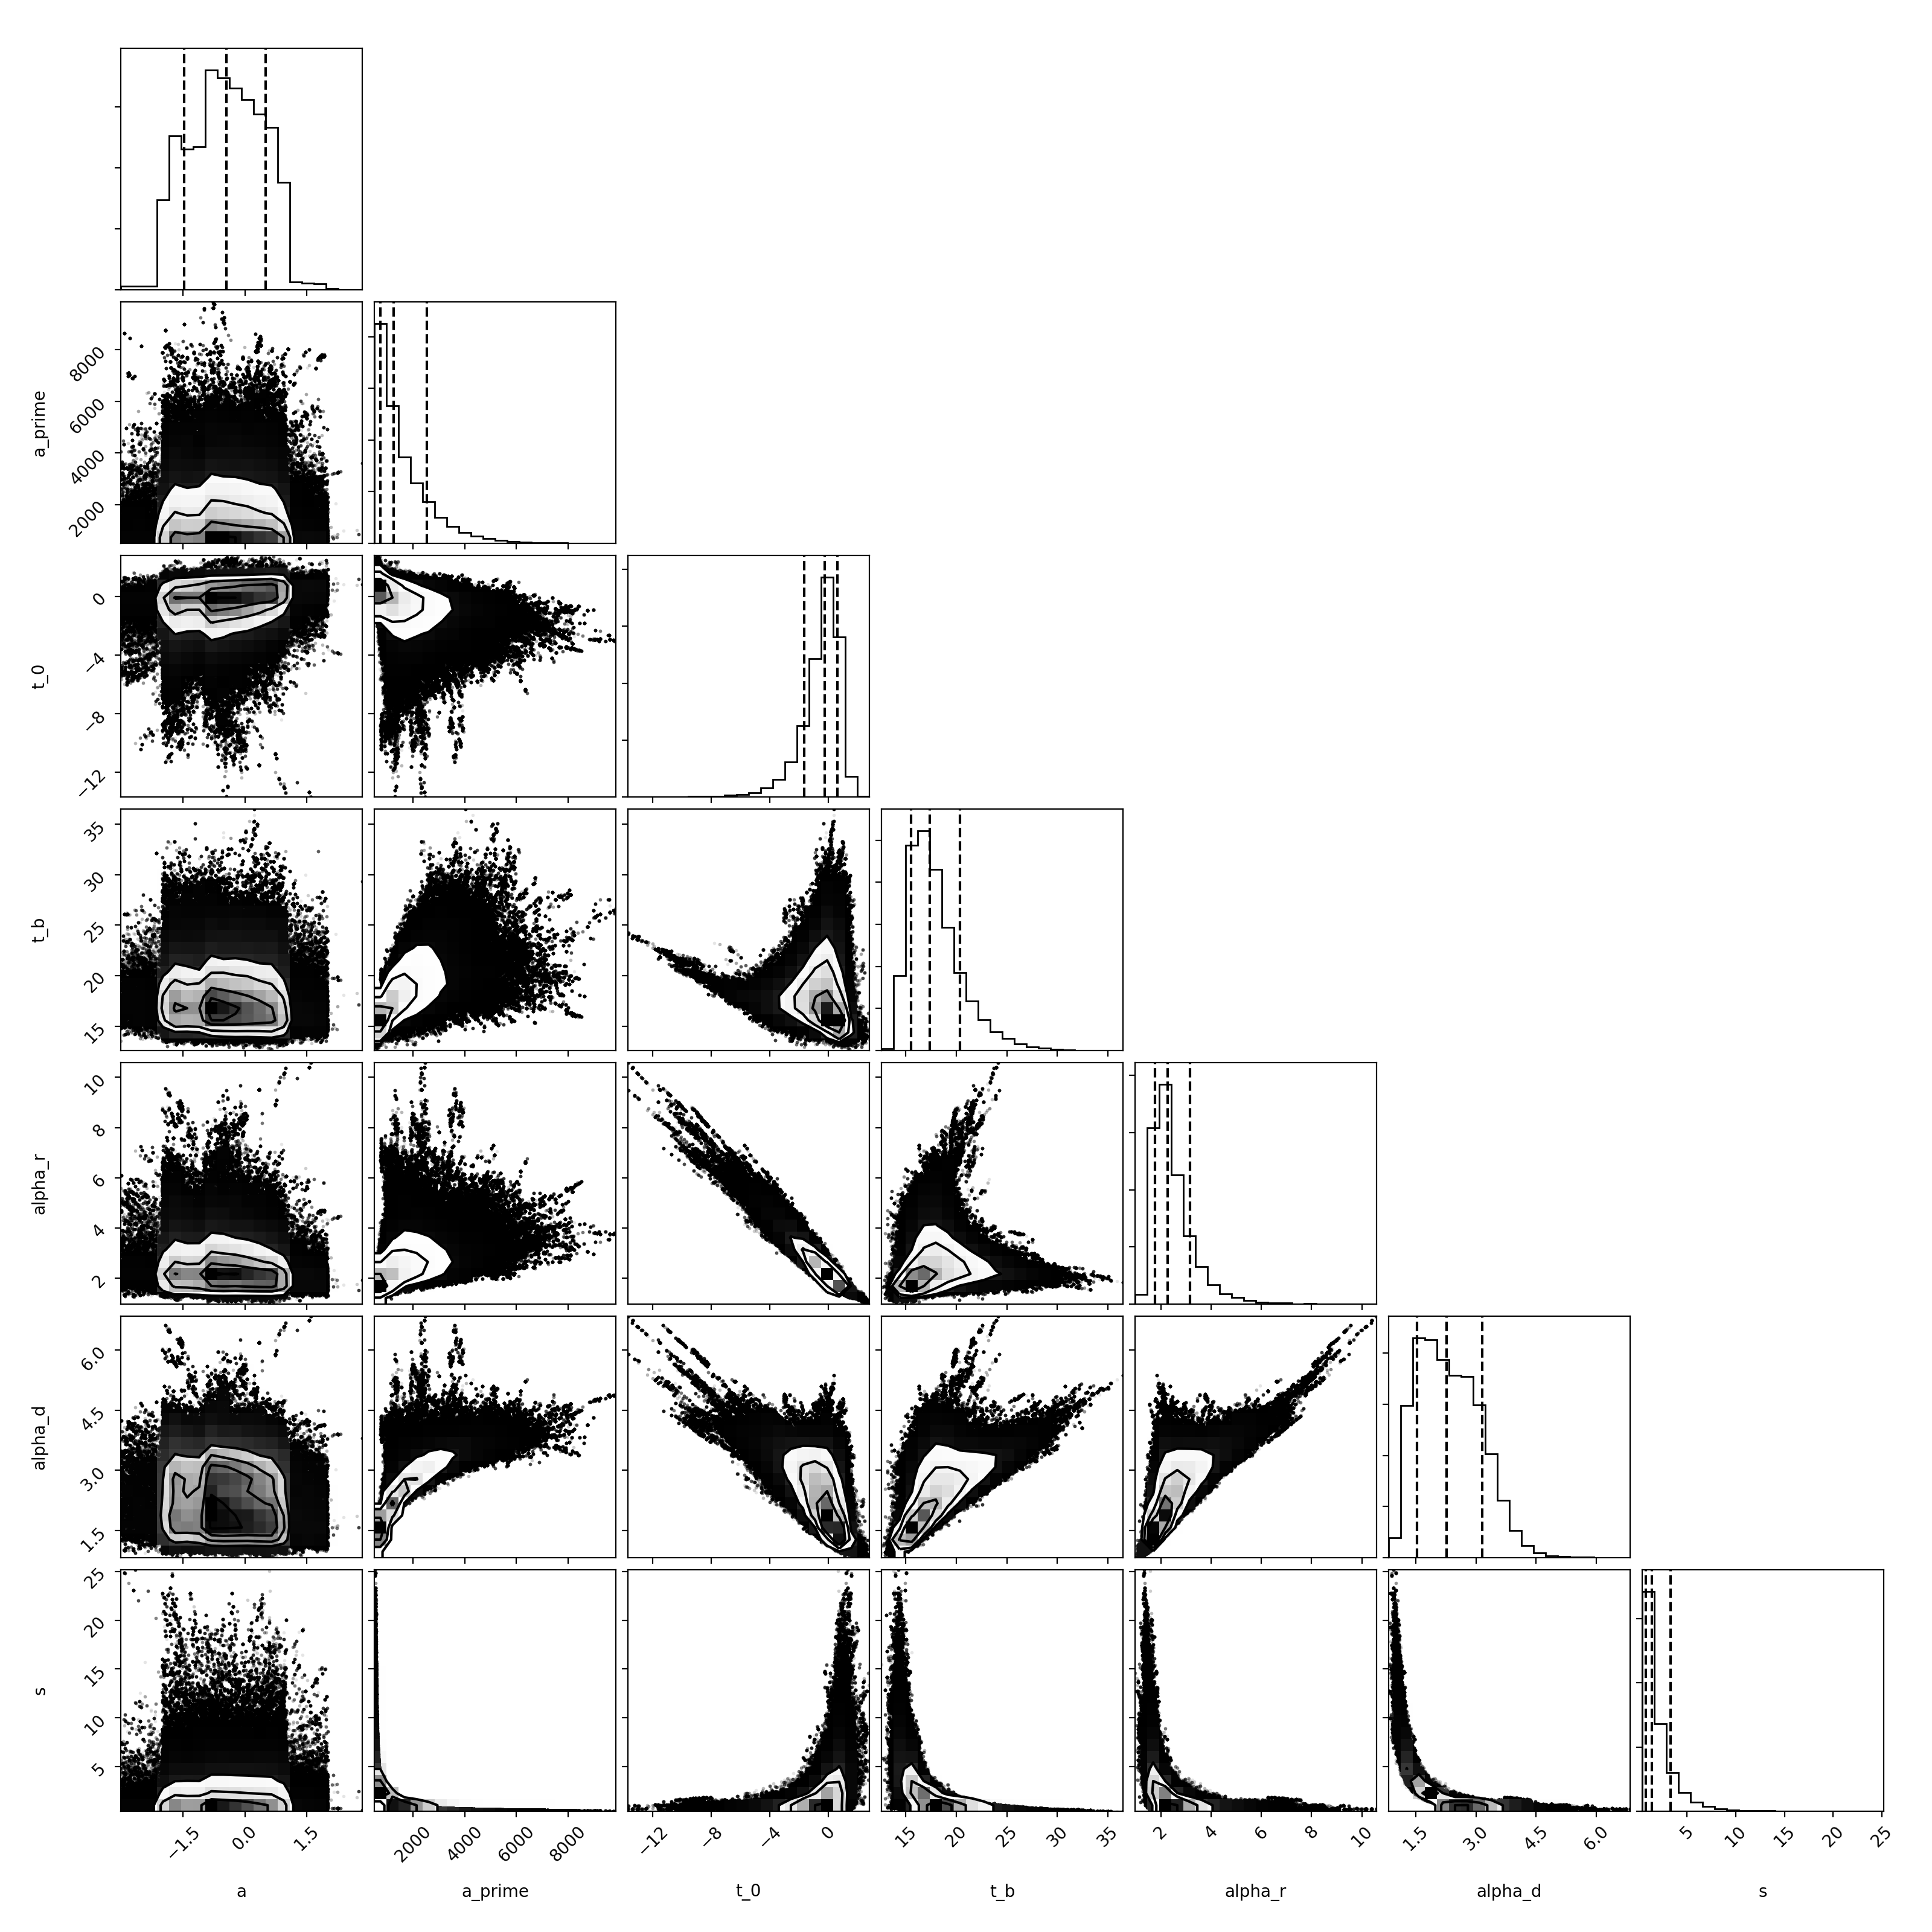

In [374]:
makeCorner(sampler, burnin, paramsNames)
plt.show()

In [158]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, )
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

paramsNames=['a', 'a_prime', 't_0', 't_b', 'alpha_r', 'alpha_d', 's']

In [141]:
t_obs=np.arange(-30,30)
cnts, cnts_unc = gen_zheng_lc(t_obs, sigma_sys=50)
def sn_lc_mcmc(sigma_sys, t_obs):
    
    cnts, cnts_unc = gen_zheng_lc(t_obs, sigma_sys=sigma_sys)
    
    t_data = t_obs
    f_data = cnts
    f_unc_data = cnts_unc

    #initial guess on parameters
    guess_0 = [0, 1e4, 0, 20, 2, 2, 1, 10]

    #number of walkers
    nwalkers = 100
    nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
    ndim = len(guess_0)
    ncores=4

    #initial position of walkers
    pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
    nsamples = 500
    foo = sampler.run_mcmc(pos, nsamples)

    # run second burn in
    burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
    pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), threads = ncores)
    nsamples = 1000
    foo = sampler.run_mcmc(pos, nsamples)
    
    return sampler

In [143]:
%%timeit
sampler = sn_lc_mcmc(200, t_obs)

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


8.86 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
import multiprocessing
from itertools import product
from functools import partial



In [145]:
%%timeit
t_obs=np.arange(-30,30)
pool = multiprocessing.Pool(4)
sampler1, sampler2, sampler3, sampler4 = pool.map(partial(sn_lc_mcmc, t_obs=t_obs), [3,5,50,316])

# pool.starmap(merge_names, product(names, repeat=2))

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountere

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountere

11.4 s ± 446 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [138]:
sampler1.flatchain

array([[-2.75479485e+01,  9.77023896e+03,  5.71246881e+00, ...,
         9.35777893e+01,  1.20997732e+01,  2.77354671e+02],
       [-2.75605273e+01,  9.77026684e+03,  5.70664073e+00, ...,
         9.36007835e+01,  1.20398424e+01,  2.77341014e+02],
       [-2.75760153e+01,  9.77024922e+03,  5.74455682e+00, ...,
         9.36026611e+01,  1.20887608e+01,  2.77347646e+02],
       ...,
       [ 2.27923518e+01,  1.13082589e+04,  6.73343699e+00, ...,
         4.29285995e+01,  5.52993269e+02,  7.66779503e+02],
       [ 7.82691677e+01,  1.07577767e+04,  6.41818843e+00, ...,
         3.91708767e+01,  7.30133662e+02,  9.74482455e+02],
       [ 1.52014769e+02,  1.07766205e+04,  6.90407062e+00, ...,
         5.20785651e+01,  1.75441776e+02,  7.79726200e+02]])